In [20]:
# gasoline prices from https://www.eia.gov/petroleum/gasdiesel/
# The prices in this document are weekly US prices since 1990.  
# State breakdowns do not start at consistent dates.

import pandas as pd

gas_prices_df = pd.read_excel("data/pswrgvwall.xls", sheet_name="Data 1", header=[0], index_col=0, skiprows=2)

In [21]:
gas_prices_df#.columns

,Weekly U.S. Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly East Coast Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly New England (PADD 1A) Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Central Atlantic (PADD 1B) Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Lower Atlantic (PADD 1C) Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Midwest Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Gulf Coast Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Rocky Mountain Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly West Coast Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Colorado Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Florida Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly New York Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Minnesota Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Ohio Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Texas Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Weekly Washington Regular Conventional Retail Gasoline Prices (Dollars per Gallon),"Weekly Cleveland, OH Regular Conventional Retail Gasoline Prices (Dollars per Gallon)","Weekly Denver, CO Regular Conventional Retail Gasoline Prices (Dollars per Gallon)","Weekly Miami, FL Regular Conventional Retail Gasoline Prices (Dollars per Gallon)","Weekly Seattle, WA Regular Conventional Retail Gasoline Prices (Dollars per Gallon)"
Date,,,,,,,,,,,,,,,,,,,,
1990-08-20,1.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-08-27,1.245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-09-03,1.242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-09-10,1.252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-09-17,1.266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,4.161,4.137,4.300,4.454,4.038,4.095,4.019,4.231,4.765,3.981,4.153,4.427,3.962,4.072,3.983,4.686,4.102,3.926,4.201,4.814
2022-05-16,4.320,4.346,4.500,4.648,4.250,4.225,4.157,4.283,4.914,4.073,4.461,4.697,4.106,4.284,4.124,4.872,4.343,4.032,4.489,4.994
2022-05-23,4.410,4.436,4.701,4.804,4.319,4.314,4.245,4.330,5.024,4.087,4.436,4.855,4.137,4.421,4.248,5.075,4.453,4.034,4.482,5.200


In [74]:
us_gas_prices = gas_prices_df['Weekly U.S. Regular Conventional Retail Gasoline Prices  (Dollars per Gallon)'].fillna(method='ffill')

In [75]:
us_gas_prices.index.dtype

dtype('<M8[ns]')

<AxesSubplot:xlabel='Date'>

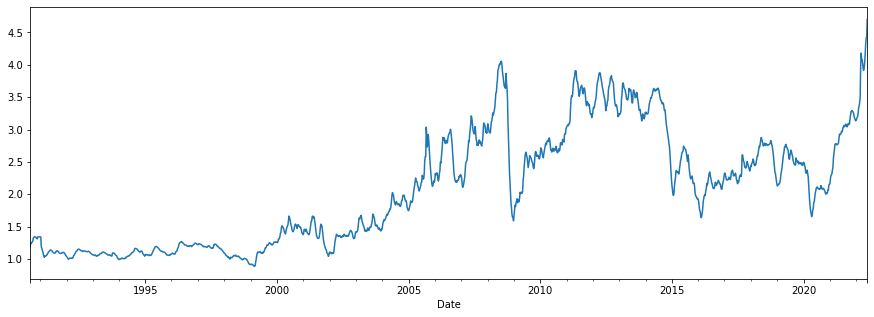

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

us_gas_prices.plot()

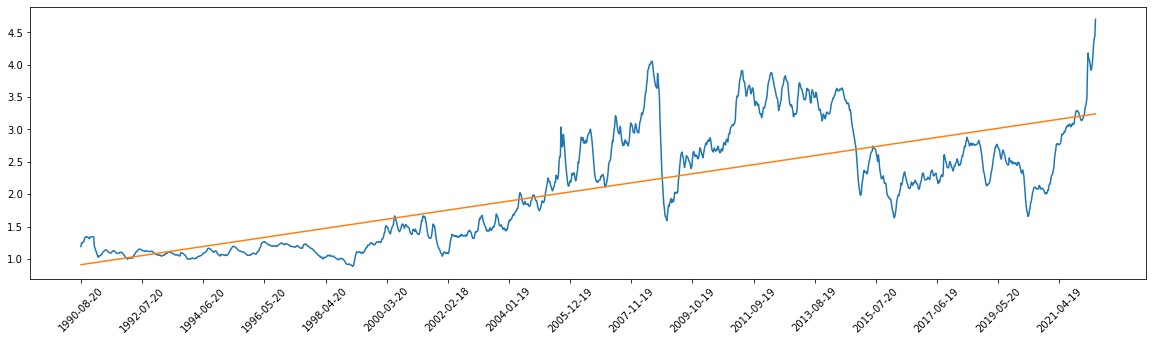

In [148]:
def plot_timeseries_with_regression(ax, x, y, xtick_interval):
    #x_int = list(range(len(x)))
    x_ind = np.array(range(x.shape[0]))
    model = np.polyfit(x_ind, y, 1)
    
    ax.plot(x_ind,y)
    ax.plot(x_ind, model[0]*x_ind + model[1])
    ax.set_xticks(x_ind[::xtick_interval])
    ax.set_xticklabels(x[::xtick_interval], rotation=45)
    return ax, model

# regression parameters
import matplotlib.dates as mdates
import numpy as np

fig, ax = plt.subplots(figsize=(20,5))

y = us_gas_prices.values
x = us_gas_prices.index.date
ax,model = plot_timeseries_with_regression(ax, x, y, 100)
plt.show()

This shows an upward trend of `0.00140439` over these years.  let's look at the log transform of this data and see if there is an exponential component to the trend.

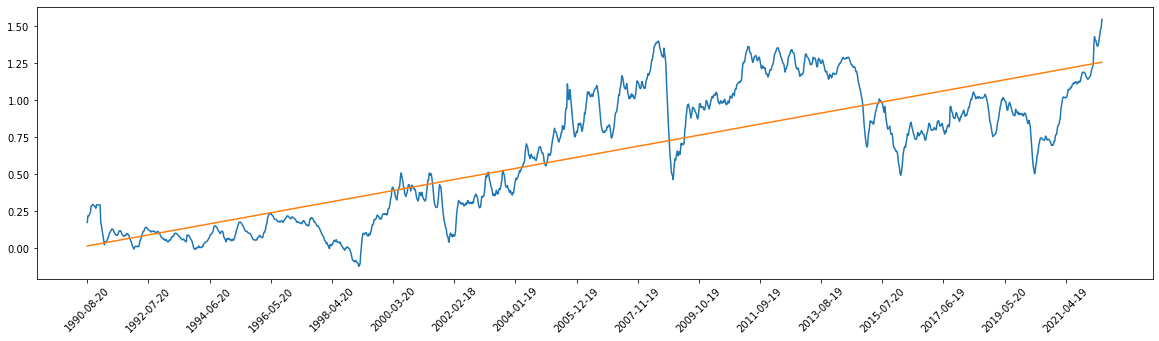

[0.00074879 0.01562767]


In [149]:
fig, ax = plt.subplots(figsize=(20,5))

y_log = np.log(us_gas_prices.values)
x = us_gas_prices.index.date

ax,model_log = plot_timeseries_with_regression(ax, x, y_log, 100)

plt.show()
print(model_log)

So there is a log trend as well, with slope `0.00074879`. Let's look at the residual plts and see how errors are distributed.

[]

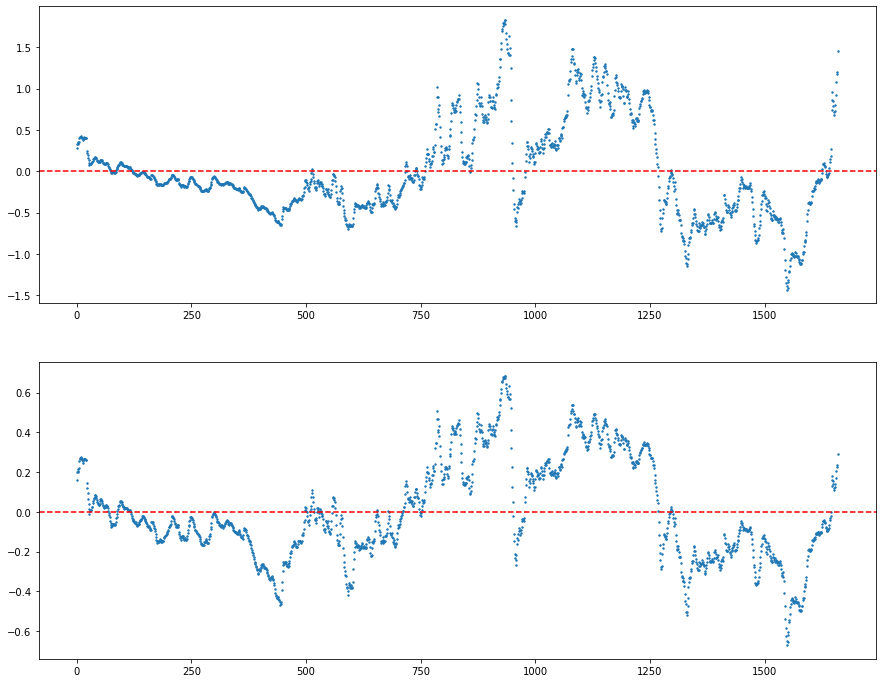

In [150]:
x_ind = np.array(range(x.shape[0]))

y_res = y - (model[1] + model[0]*x_ind)
y_log_res = y_log - (model_log[1] + model_log[0]*x_ind)

fig, axs = plt.subplots(2, 1, figsize=(15,12))

axs[0].scatter(x_ind, y_res, s=2)
axs[0].axhline(0, color='red', linestyle='--')

axs[1].scatter(x_ind, y_log_res, s=2)
axs[1].axhline(0, color='red', linestyle='--')

plt.plot()

 Lets look at the correlogram for these two plots.

In [151]:
def autocorr(samples, lag):
        l = len(samples)
        assert(lag < l)
        
        x_bar = np.mean(samples)
        xs = samples
        s = 0
        for i in range(len(xs)-lag):
            s+=(xs[i]-x_bar)*(xs[i+lag]-x_bar)
            
        xs_var2 = sum([(x-x_bar)**2 for x in xs])
        return s/xs_var2
    
# define the autocorrelation function
def acf(samples, lim=30):
    return [autocorr(samples, k+1) for k in list(range(lim))]

# plot N lags using the acf
def plot_acf(ax, N, samples):
    xs = [k+1 for k in list(range(N))]
    ys = acf(samples, lim=N)
    ax.scatter(xs, ys)
    ax.vlines(xs, 0, ys)
    ax.axhline(2/np.sqrt(len(samples)), linestyle='--', color="r")
    ax.axhline(-2/np.sqrt(len(samples)), linestyle='--', color="r")
    return ax


#    plt.title(f'Autocorrelation for lag 1 to {N}')
#plt.ylabel('Data')
#plt.xlabel('Lag')
#plt.grid(True)


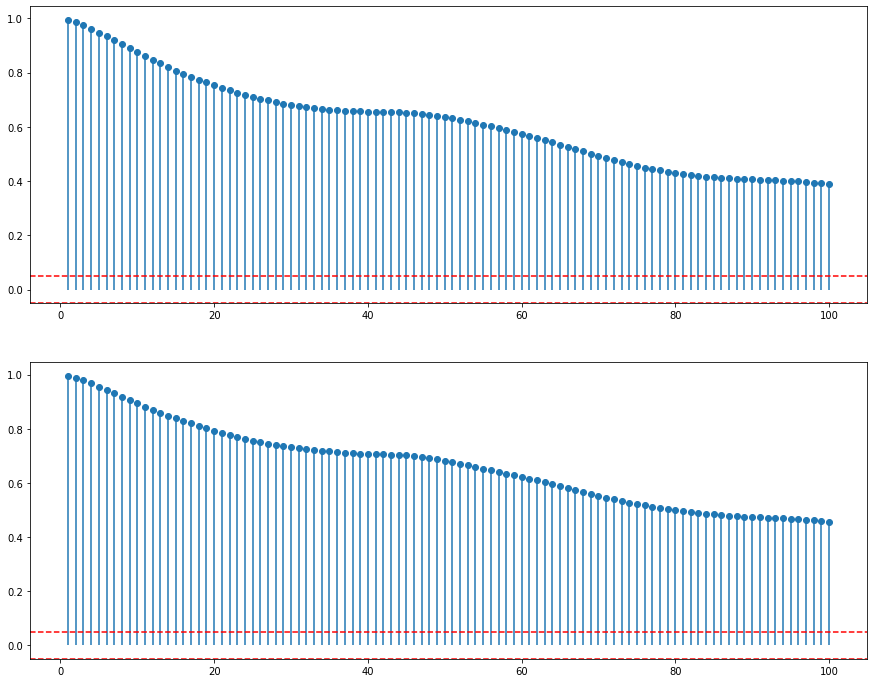

In [152]:
fig, axs = plt.subplots(2, 1, figsize=(15,12))

axs = axs.flatten()

axs[0] = plot_acf(axs[0], 100, y_res)
axs[1] = plot_acf(axs[1], 100, y_log_res)

_ = plt.show()


So these data are highly correlated in time based on these samples.  the linear regression does not seem to capture any of the correlated behavior of the series.  The price of gasoline is highly influenced by the previous weeks' prices.  Is this the same for the **change in gasoline price week on week**?

1659
1659


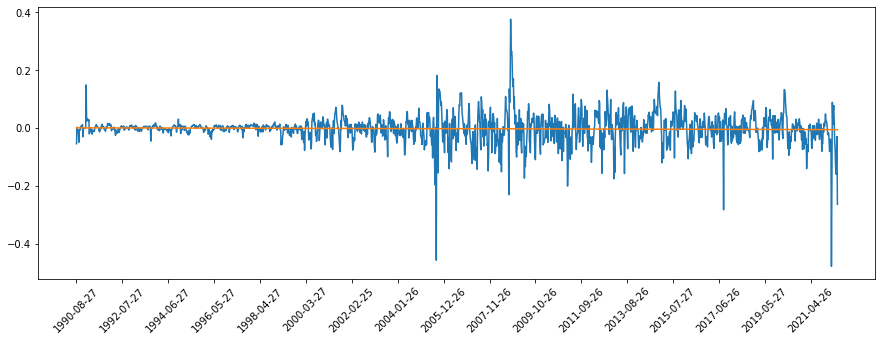

[-3.79698478e-06  1.03136524e-03]


In [153]:
delta_y = us_gas_prices.values[:-1] - us_gas_prices.values[1:]
print(delta_y.shape[0])
x = us_gas_prices.index.date[1:]

print(x.shape[0])
fig, ax = plt.subplots(figsize=(15,5))

ax,model_diff = plot_timeseries_with_regression(ax, x, delta_y, 100)

plt.show()
print(model_diff)

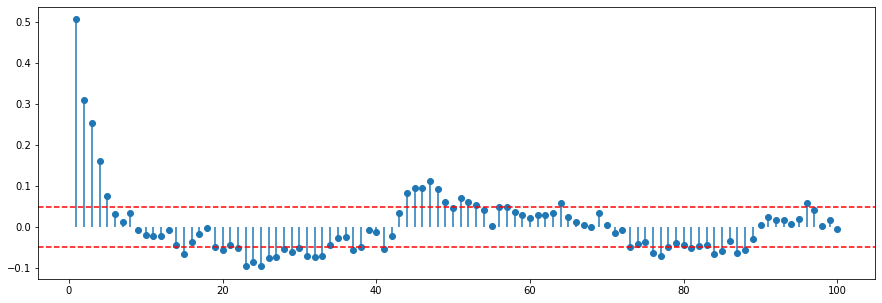

In [154]:
fig, ax = plt.subplots(figsize=(15,5))

ax = plot_acf(ax, 100, delta_y)

plt.show()

There are still some strong long-running corellation in the diff result, implying that the change of price is correlated with the preveous few weeks' changes in price.  There seems to be a roughly periodic behavior to the price.  What about another diff?

1658


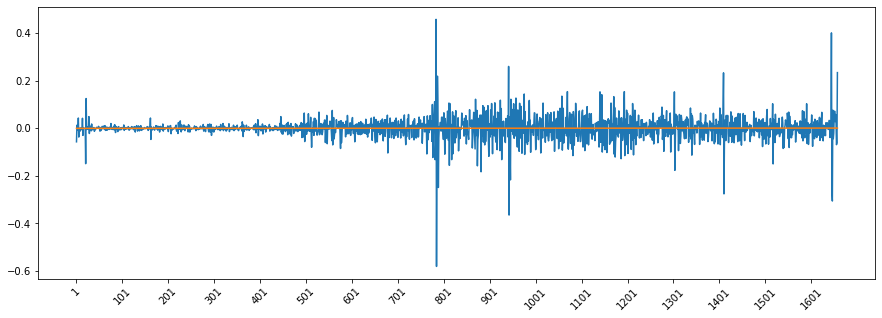

[ 6.83070607e-07 -4.39868510e-04]


In [156]:
dd_y = delta_y[:-1]-delta_y[1:]

print(len(dd_y))

fig, ax = plt.subplots(figsize=(15,5))

x = np.array(range(us_gas_prices.index.shape[0]))[1:-1]

ax,model_dd = plot_timeseries_with_regression(ax, x, dd_y, 100)

plt.show()
print(model_dd)

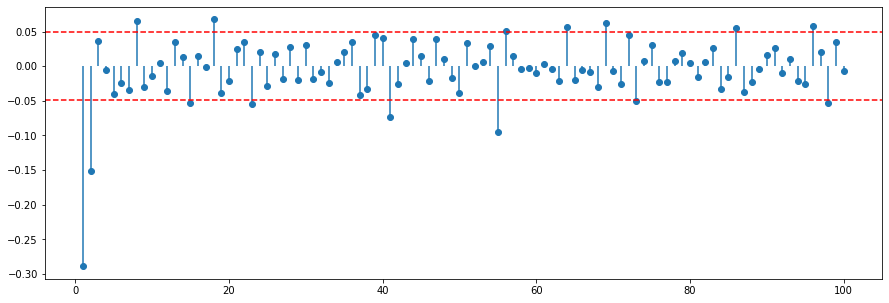

In [158]:
fig, ax = plt.subplots(figsize=(15,5))

ax = plot_acf(ax, 100, dd_y)

plt.show()

the second order difference shows correlation of the first two time steps implying that the rate of change of prices week on week is correlated with previous two weeks' rates of change.  

one interesting result is that high and low spikes in the 2nd order data are paired.  We can locate the times of high variances by looking for these pairs.  what events are they correlated to?

We can put this question aside for a moment and look at how we can use this info to create and arima model of these prices.  we will use statsmodels to do this.  we will use `p = 2, d = 2, q = 3`.

                                                             SARIMAX Results                                                             
Dep. Variable:     Weekly U.S. Regular Conventional Retail Gasoline Prices  (Dollars per Gallon)   No. Observations:                 1660
Model:                                                                            ARIMA(2, 2, 4)   Log Likelihood                2878.211
Date:                                                                           Sun, 12 Jun 2022   AIC                          -5742.422
Time:                                                                                   08:45:49   BIC                          -5704.529
Sample:                                                                               08-20-1990   HQIC                         -5728.376
                                                                                    - 06-06-2022                                         
Covariance Type:                  

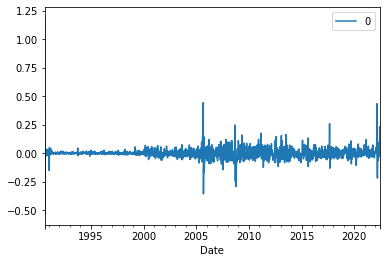

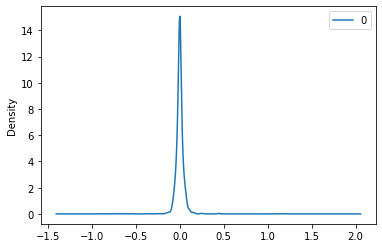

In [167]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(us_gas_prices, order=(2,2,4))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
print(type(model_fit.resid))
residuals = pd.DataFrame(model_fit.resid)
print(residuals.mean())
# summary stats of residuals
print(residuals.describe())
residuals.plot()
#pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
_ = plt.show()


In [168]:
# The above model is a guess.  Lets run a grid search for a more effective model.

import warnings
warnings.filterwarnings("ignore")

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.90)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    mean = model_fit.resid.mean()
    return error, mean

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse, mean = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f, mean=%.3f' % (order,mse,mean))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [169]:
# evaluate parameters
p_values = range(2,3)
d_values = range(2,3)
q_values = range(0,5)
warnings.filterwarnings("ignore")
evaluate_models(us_gas_prices.values, p_values, d_values, q_values)

Best ARIMANone MSE=inf
